# Carey's experiment

2-block SBM G ~ SBM(n, pi, B)  
B = [p^2, pq; pq, q^2]  
p, q = 1/3, 1/4

just setting an even number n=500 of nodes in each community, since code for drawing node communities stochastically isn't as accessible (e.g., I don't know where it is... and I think it shouldn't change much? maybe I'm wrong?)

so the pi inputted into `vfun` = 1/2 in this case, I think? so that it can be a scalar?  

nodes in community 1 drawn from N(q, vfun(pi, q, p, ci=1)/n)  
nodes in community 2 drawn from N(q, vfun(pi, q, p, ci=2)/n)  

## did I do it right, not actually sure

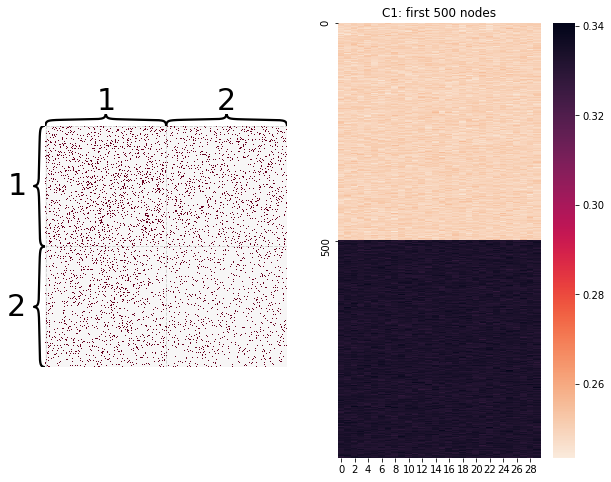

In [1]:
import numpy as np
from scipy.stats import norm
from graspologic.simulations import sbm
from graspologic.plot import heatmap
import seaborn as sns
from matplotlib import pyplot as plt

def vfun(pi, p, q, ci=1):
    if ci==1:
        num = pi*p**4*(1-p**2) + (1-pi)*p*q**3*(1-p*q)
    else:
        num = pi*p**3*q*(1-p*q) + (1-pi)*q**4*(1-q**2)
    
    denom = ((pi*p**2 + (1-pi)*q**2))**2
    return num / denom

def make_community(mu, sig, n=500):
    return norm.rvs(mu, sig, size=(n, 30))

def gen_covariates(p, q, pi):
    n = 500
    c1 = make_community(q, vfun(pi, q, p, ci=1)/n, n=n)
    c2 = make_community(p, vfun(1-pi, p, q, ci=2)/n)

    covariates = np.vstack((c1, c2))
    return covariates

p, q = 1/3, 1/4
B = np.array([[p**2, p*q],
              [p*q, q**2]])
pi = 1/2
n = 500

A, labels = sbm([n, n], B, return_labels=True)
labels += 1

X = gen_covariates(p, q, pi)

fig, axs = plt.subplots(1, 2, figsize=(10,8))
heatmap(A, ax=axs[0], inner_hier_labels=labels, cbar=False)
sns.heatmap(X, cmap="rocket_r", yticklabels=500, ax=axs[1])
axs[1].set(title="C1: first 500 nodes");

In [2]:
from graspologic.embed import CovariateAssistedEmbed as CASE
from graspologic.plot import pairplot

case = CASE(n_components=1)
latents = case.fit_transform(A, covariates=X)

# pairplot(latents, labels=labels)

## default alpha isn't super reasonable

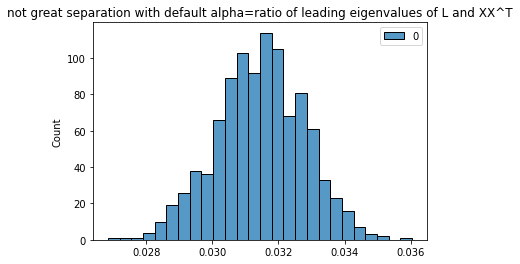

In [3]:
ax = sns.histplot(latents)
ax.set_title("not great separation with default alpha=ratio of leading eigenvalues of L and XX^T");

/Users/alex/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'into 2 dimensions'}>

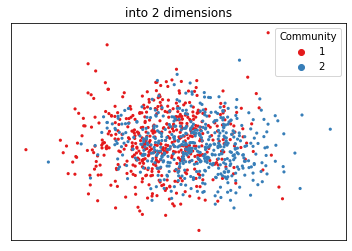

In [4]:
def plot_latents(latent_positions, *, title, labels, ax=None):
    if ax is None:
        ax = plt.gca()
    plot = sns.scatterplot(latent_positions[:, 0], latent_positions[:, 1], hue=labels, 
                           linewidth=0, s=10, ax=ax, palette="Set1")
    plot.set_title(title, wrap=True);
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.legend(loc="upper right", title="Community")
    
    return plot

case = CASE(n_components=2)
latents = case.fit_transform(A, covariates=X)

plot_latents(latents, title="into 2 dimensions", labels=labels)

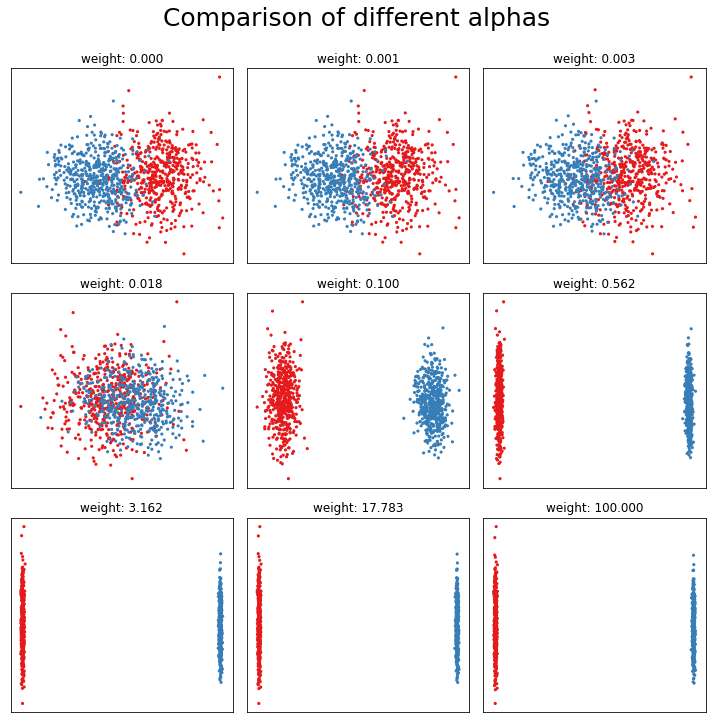

In [5]:
from warnings import filterwarnings
filterwarnings("ignore")

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for a, ax in zip(np.geomspace(10e-5, 100, num=9), axs.flat):
    case = CASE(n_components=2, alpha=a)
    l_ = case.fit_transform(A, covariates=X)
    plot_latents(l_, title=f"weight: {a:.3f}", labels=labels, ax=ax)
    ax.get_legend().remove()
    
fig.suptitle(r"Comparison of different alphas", y=1, fontsize=25);
plt.tight_layout()

## embedding with a reasonable alpha

use alpha=.1

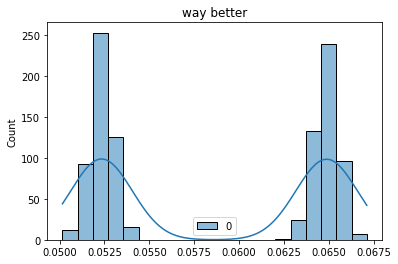

In [6]:
case = CASE(n_components=1, alpha=0.1)
latents = case.fit_transform(A, covariates=X)

ax = sns.histplot(latents, bins=20, kde=True)
ax.set_title("way better");